# Coding exercises from chapter 19 - Risk management

# 19.3 Portfolio Risk Management.
## a. Download daily historical data for the last ten years for the assets [...]. Clean as appropriate.

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
tickers = ['SPY', 'DBC', 'SVXY', 'HYG', 'EEM', 'AGG',] 
start_date = '2013-01-01'
end_date = '2023-12-31'

# Download the data
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  6 of 6 completed


In [119]:
data[:252] # we remove $EAFE and $IAGG as they do not have price data for the whole period. 
# We could also simply select a shorter period

,AGG,DBC,EEM,HYG,SPY,SVXY
Date,,,,,,
2013-01-02,85.541786,26.926001,36.192566,53.529358,119.976517,73.459999
2013-01-03,85.325882,26.703871,35.936447,53.364620,119.705399,72.849998
2013-01-04,85.418396,26.587978,36.008469,53.398708,120.231148,74.330002
2013-01-07,85.372101,26.636267,35.736355,53.444141,119.902550,74.300003
2013-01-08,85.449242,26.703871,35.416199,53.404362,119.557549,75.150002
...,...,...,...,...,...,...
2013-12-24,83.964020,24.859230,33.562965,55.949455,153.296463,136.610001
2013-12-26,83.916695,24.897861,33.276592,56.001995,154.075836,139.009995
2013-12-27,83.948219,24.965464,33.792068,55.995960,154.067505,136.979996


## b. Using a two-year rolling window and the historical simulation method discussed in the chapter, calculate a daily VaR and CVaR for the portfolio using a 5% threshold. Plot both on the same chart and comment on their relationship to each other, as well as their evolution over time.

### We start coding the 2y rolling daily VaR/CVaR using the realized returns, without bootstrapping.

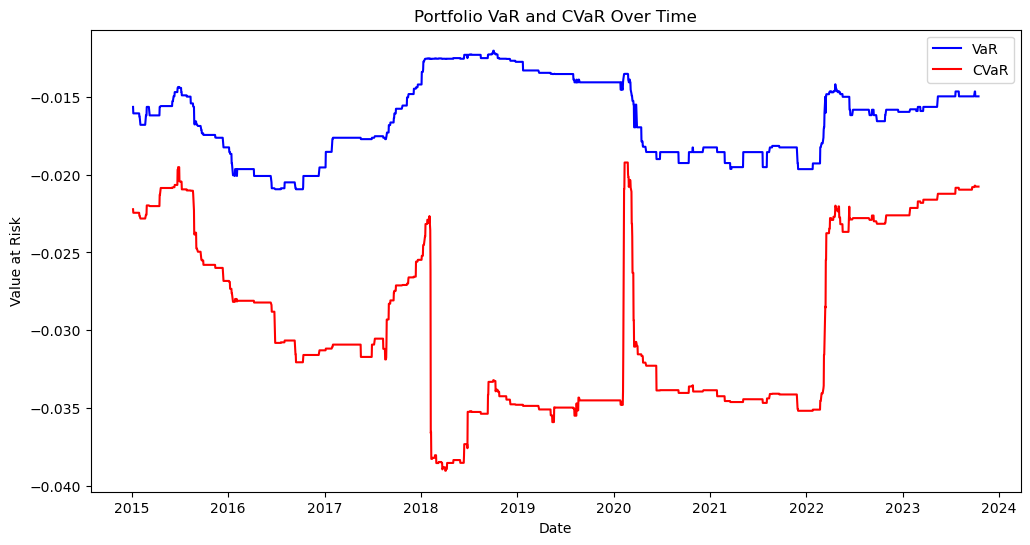

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load daily return data for the portfolio (replace with your data)
# portfolio_returns should be a DataFrame with date as index and portfolio returns as a column.
returns = np.log(data/data.shift(1)).dropna()
portfolio_returns = returns.mean(axis=1)

# Parameters
rolling_window = 2 * 252  # Two years of trading days
threshold = 0.05  # 5% threshold

# Initialize lists to store VaR and CVaR values
var_values = []
cvar_values = []

# Calculate VaR and CVaR using a rolling window
for i in range(rolling_window, len(portfolio_returns)):
    returns_window = portfolio_returns.iloc[i - rolling_window:i]
    var = np.percentile(returns_window, threshold * 100)
    cvar = returns_window[returns_window <= var].mean()
    var_values.append(var)
    cvar_values.append(cvar)

# Create a DataFrame for VaR and CVaR
var_df = pd.DataFrame({'VaR': var_values, 'CVaR': cvar_values}, index=portfolio_returns.index[rolling_window:])
# Plot VaR and CVaR
plt.figure(figsize=(12, 6))
plt.plot(var_df.index, var_df['VaR'], label='VaR', color='blue')
plt.plot(var_df.index, var_df['CVaR'], label='CVaR', color='red')
plt.xlabel('Date')
plt.ylabel('Value at Risk')
plt.title('Portfolio VaR and CVaR Over Time')
plt.legend()
plt.show()

### Now we adapt the function bootstrapSyntheticReturns() provided in the book. The previous code executed inmediately but this one lasted 1.5 hours.

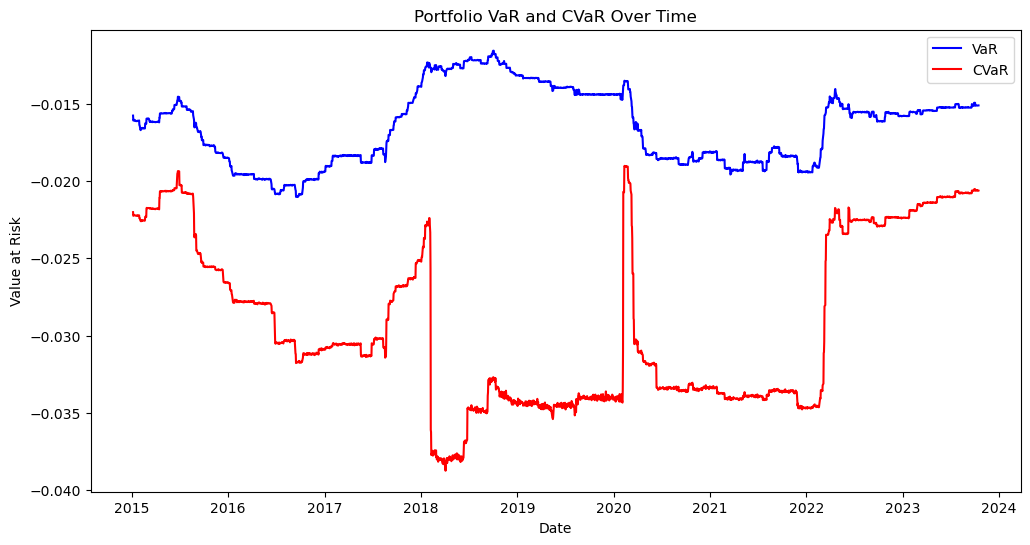

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from random import choices

def bootstrapSyntheticReturns(historicalReturns, numberOfPaths, pathLength):
  #  print("Entering bootstrapSyntheticReturns")
    if (len(historicalReturns.shape) > 1):
        nAssets = historicalReturns.shape[1]
        
    paths = np.zeros((pathLength, nAssets, numberOfPaths))
    for path in range(numberOfPaths):
        dateIdcs = choices(range(1, len(historicalReturns)), k=pathLength) #with replacement
        dateIndices = np.array(dateIdcs)
        paths[:, :, path] = historicalReturns.iloc[dateIndices, :].values
    #    print("Path created:", paths[:, :, path])
 #   print("Exiting bootstrapSyntheticReturns")
    return paths

returns = np.log(data/data.shift(1)).dropna()

# Parameters
rolling_window = 2 * 252  # Two years of trading days
threshold = 0.05  # 5% threshold

# Initialize lists to store VaR and CVaR values
var_plot = []
cvar_plot = []

for i in range(rolling_window, len(returns)):
    returns_window = returns.iloc[i - rolling_window:i]
    var_values = []  # Reset var_values and cvar_values for each rolling window
    cvar_values = []  # Reset var_values and cvar_values for each rolling window
    paths = bootstrapSyntheticReturns(historicalReturns=returns_window, numberOfPaths=10000, pathLength=2*252)
    
    for path in range(paths.shape[2]):
        portfolio_returns = paths[:, :, path].mean(axis=1)
        var = np.percentile(portfolio_returns, threshold * 100)
        cvar = np.mean(portfolio_returns[portfolio_returns <= var])
        var_values.append(var)
        cvar_values.append(cvar)

    var_plot.append(np.mean(var_values))
    cvar_plot.append(np.mean(cvar_values))
    
# Create a DataFrame for VaR and CVaR
var_df = pd.DataFrame({'VaR': var_plot, 'CVaR': cvar_plot}, index=returns.index[rolling_window:])
# Plot VaR and CVaR
plt.figure(figsize=(12, 6))
plt.plot(var_df.index, var_df['VaR'], label='VaR', color='blue')
plt.plot(var_df.index, var_df['CVaR'], label='CVaR', color='red')
plt.xlabel('Date')
plt.ylabel('Value at Risk')
plt.title('Portfolio VaR and CVaR Over Time')
plt.legend()
plt.show()       

## c. Plot the VaR against the returns of the portfolio. Comment on how often the VaR is breached.

### We use the version that does not make use of bootstrapping to solve sections c. and d., as it is much faster and the results are almost the same.

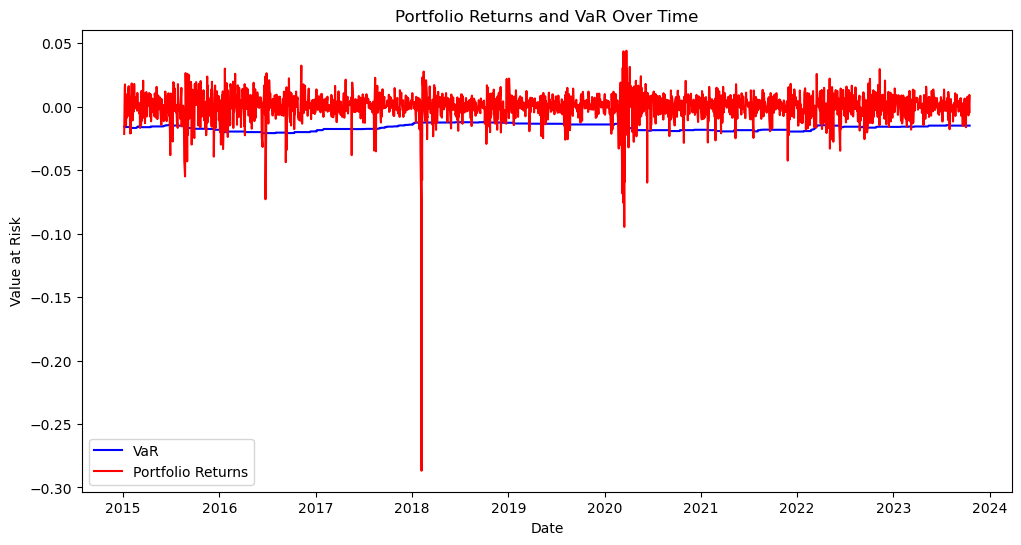

The VaR threshold is crossed 116 times
Out of the 2212 total returns we have for the period, that means a total of 5.24% of the returns are below the VaR threshold


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load daily return data for the portfolio (replace with your data)
returns = np.log(data / data.shift(1)).dropna()
portfolio_returns = returns.mean(axis=1)

# Parameters
rolling_window = 2 * 252  # Two years of trading days
threshold = 0.05  # 5% threshold

# Initialize lists to store VaR and CVaR values
var_values = []
crossings = 0  # Initialize a counter for threshold crossings

# Calculate VaR and CVaR using a rolling window
for i in range(rolling_window, len(portfolio_returns)):
    returns_window = portfolio_returns.iloc[i - rolling_window:i]
    var = np.percentile(returns_window, threshold * 100)
    var_values.append(var)

# Create a DataFrame for VaR
var_df = pd.DataFrame({'VaR': var_values}, index=portfolio_returns.index[rolling_window:])

# Count the number of times VaR threshold is crossed
for i in range(len(var_values)):
    if portfolio_returns[504:].iloc[i] < var_values[i]: # show returns after 2 years for comparision
        crossings += 1

# Plot VaR and Portfolio Returns
plt.figure(figsize=(12, 6))
plt.plot(var_df.index, var_df['VaR'], label='VaR', color='blue')
plt.plot(var_df.index, portfolio_returns[rolling_window:], label='Portfolio Returns', color='red')
plt.xlabel('Date')
plt.ylabel('Value at Risk')
plt.title('Portfolio Returns and VaR Over Time')
plt.legend()
plt.show()

print(f"The VaR threshold is crossed {crossings} times")
print(f"Out of the {len(portfolio_returns[504:])} total returns we have for the period, that means a total of {crossings / len(portfolio_returns[504:]) * 100:.2f}% of the returns are below the VaR threshold")

## d. Calculate the total VaR contribution for each asset by setting each weight to zero and re-calculating the VaR. Comment on which assets seems to be contributing the most and least to the total VaR.

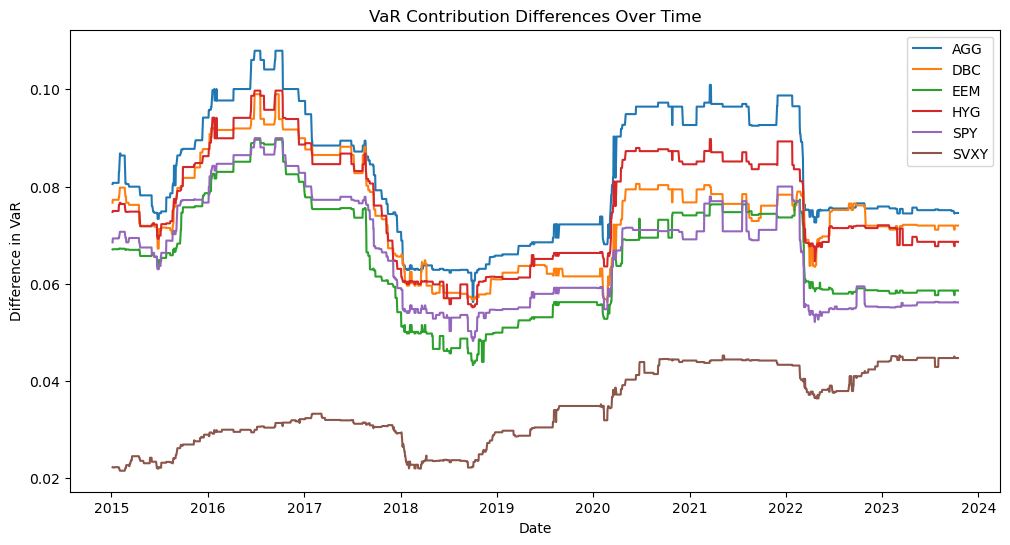

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load daily return data for the portfolio (replace with your data)
# portfolio_returns should be a DataFrame with date as index and portfolio returns as a column.
returns = np.log(data/data.shift(1)).dropna()
portfolio_returns = returns.mean(axis=1)

# Parameters
rolling_window = 2 * 252  # Two years of trading days
threshold = 0.05  # 5% threshold

# Get the number of assets
num_assets = len(data.columns)

# Initialize a DataFrame to store the differences
differences = pd.DataFrame(columns=data.columns)

# Calculate the portfolio VaR without excluding any assets
var_values = []
for i in range(rolling_window, len(portfolio_returns)):
    returns_window = portfolio_returns.iloc[i - rolling_window:i]
    var = np.percentile(returns_window, threshold * 100)
    var_values.append(var)

# Loop through each asset and set its weight to zero
for asset in data.columns:
    cont_weights = pd.Series(1.0, index=data.columns)
    cont_weights[asset] = 0.0  # Set the weight of the current asset to zero
    weighted_portfolio_returns = (cont_weights * returns).sum(axis=1)
    
    # Calculate the portfolio VaR for the modified portfolio
    var_values_modified = []
    for i in range(rolling_window, len(weighted_portfolio_returns)):  
        returns_window = weighted_portfolio_returns.iloc[i - rolling_window:i]
        var = np.percentile(returns_window, threshold * 100)
        var_values_modified.append(var)

    # Compute the difference between the portfolio VaR and VaR with the asset weight set to zero
    differences[asset] = np.array(var_values) - np.array(var_values_modified)

# Plot the differences over time for each asset
plt.figure(figsize=(12, 6))
for asset in differences.columns:
    plt.plot(portfolio_returns.index[rolling_window:], differences[asset], label=asset)

plt.xlabel('Date')
plt.ylabel('Difference in VaR')
plt.title('VaR Contribution Differences Over Time')
plt.legend()
plt.show()

### Investment grade, and high yield ETFs contribute more to VaR than the commodities and SPY ETFs. The least risk added is given by SVXY. A proof that we cannot predict the future, as SVXY had an spectacular performance until 2018 when it dropped 91% in one month. 

# 19.4 Risk management in rates
## a. Download data for 2y, 5y, 10y and 30y treasury yields. Clean the data as you see fit.

In [80]:
import pandas as pd

# the 2y is not in yfinance. We therefore download data from investing.com

bond_2y =pd.read_csv("United States 2-Year Bond Yield Historical Data.csv")
bond_5y =pd.read_csv("United States 5-Year Bond Yield Historical Data.csv")
bond_10y=pd.read_csv("United States 10-Year Bond Yield Historical Data.csv")
bond_30y=pd.read_csv("United States 30-Year Bond Yield Historical Data.csv")
bond_1y =pd.read_csv("United States 1-Year Bond Yield Historical Data.csv") # for disc rate

#clean the tables
datasets = [bond_2y, bond_5y, bond_10y, bond_30y]

for dataset in datasets:
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset.set_index('Date', inplace=True)
    dataset.drop(dataset.columns.difference(['Price']), axis=1, inplace=True)

In [81]:
# Rename columns in each DataFrame
bond_2y.rename(columns={'Price': '2y'}, inplace=True)
bond_5y.rename(columns={'Price': '5y'}, inplace=True)
bond_10y.rename(columns={'Price': '10y'}, inplace=True)
bond_30y.rename(columns={'Price': '30y'}, inplace=True)

# Merge the DataFrames using the 'index' as the key
ts_yields = pd.concat([bond_2y, bond_5y, bond_10y, bond_30y], axis=1, join='inner')

# For ts_prices
ts_yields = ts_yields[::-1]
ts_yields = ts_yields[125:] # to start from the same date as the swaps

bond_1y = bond_1y[1:]
bond_1y = bond_1y[::-1]
ts_yields['1y']=bond_1y['Price'].values

### b. Assume that you purchased the 2y, 5y, 10y and 30y treasuries at the latest available yield and that the coupon is equal to the yield. Estimate the change in price to each treasury along each path based on the change in yields. Plot the changes to the treasury prices for each maturity over all paths.

In [68]:
buy_yields = ts_yields.iloc[-1] # we purchase these securities at the issuance and assume a rate equal to the coupon
buy_yields

2y     5.175
5y     4.838
10y    4.819
30y    4.947
1y     5.449
Name: 2023-10-18 00:00:00, dtype: float64

In [69]:
def calculate_bond_price(coupon_rate, maturity, face_value, disc_rate):
    # Initialize the present value of coupon payments
    pv_coupons = 0

    # Calculate the present value of coupon payments for each year
    for year in range(1, maturity + 1):
        coupon_payment = (coupon_rate / 100) * face_value
        pv_coupon_payment = coupon_payment / ((1 + (disc_rate / 100)) ** year)
        pv_coupons += pv_coupon_payment

    # Calculate the present value of the face value payment
    face_value_payment = face_value / ((1 + (disc_rate / 100)) ** maturity)

    # Calculate the bond price
    bond_price = pv_coupons + face_value_payment

    return bond_price

coupons = buy_yields  # Coupon rates for 2y, 5y, 10y, 30y
maturities = [2, 5, 10, 30]  # Maturities in years
face_value = 1000  # Face value for all bonds
disc_rate = 5.44

# Initialize an empty list to store bond prices
bond_prices = []

# Calculate the bond prices for each bond
for i in range(4):
    coupon_rate = coupons[i]
    maturity = maturities[i]

    bond_price = calculate_bond_price(coupon_rate, maturity, face_value, disc_rate)
    bond_prices.append(bond_price)

print(bond_prices)

[995.1031129614237, 974.2505354182265, 953.0563361135345, 927.8713528645367]


### The variance across paths will depend on the lookback period that we use to simulate the next randomly chosen yield, and the exercise do not say what period should we use. We take 1 trading year.

In [70]:
import numpy as np
from random import choices
def bootstrapSyntheticReturns(historicalReturns, numberOfPaths, pathLength):
  #  print("Entering bootstrapSyntheticReturns")
    if (len(historicalReturns.shape) > 1):
        nAssets = historicalReturns.shape[1]
    else:
        nAssets=1
        
    paths = np.zeros((pathLength, nAssets, numberOfPaths))
    for path in range(numberOfPaths):
        dateIdcs = choices(range(1, len(historicalReturns)), k=pathLength) #with replacement
        dateIndices = np.array(dateIdcs)
        paths[:, :, path] = historicalReturns.iloc[dateIndices, :].values
    #    print("Path created:", paths[:, :, path])
 #   print("Exiting bootstrapSyntheticReturns")
    return paths
paths=bootstrapSyntheticReturns(ts_yields[-252:], numberOfPaths=10000, pathLength=1)

In [71]:
paths[:, 0, :]

array([[4.081, 5.014, 4.728, ..., 5.127, 3.792, 5.054]])

In [72]:
initial_prices = bond_prices  # Initial bond prices
maturities = [2, 5, 10, 30]  # Maturities in years

# Extract yield scenarios from the 'paths' array for each maturity
coupon_scenarios = [paths[:, i, :] for i in range(4)]  # 4 maturities

# Initialize lists to store bond prices for each maturity
bond_prices_2y = []
bond_prices_5y = []
bond_prices_10y = []
bond_prices_30y = []

# Calculate bond prices for each maturity and yield scenario
for i, maturity in enumerate(maturities):
    maturity_prices = []  # Initialize list for this maturity

    for coupon_scenario in coupon_scenarios[i]:
        # Calculate bond price using the provided function
        new_price = calculate_bond_price(coupon_scenario, maturity, face_value=1000, disc_rate = 5.44) # we assume the rest of
        # rates are constant
        maturity_prices.append(new_price)

    # Store the bond prices for this maturity in the corresponding array
    if maturity == 2:
        bond_prices_2y.append(maturity_prices)
    elif maturity == 5:
        bond_prices_5y.append(maturity_prices)
    elif maturity == 10:
        bond_prices_10y.append(maturity_prices)
    elif maturity == 30:
        bond_prices_30y.append(maturity_prices)

In [73]:
bond_prices_2y[0][0] # double nested array

array([974.88728496, 992.1280231 , 986.84308086, ..., 994.21612965,
       969.54690627, 992.86717586])

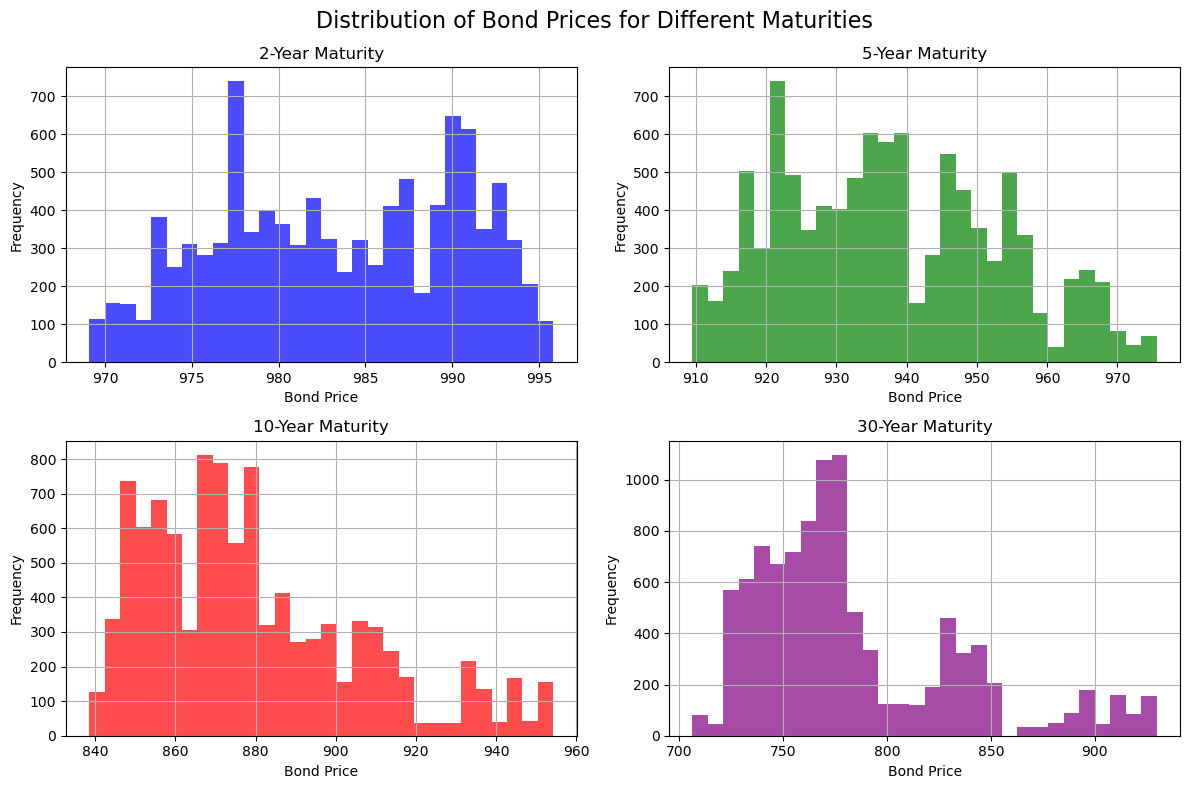

In [74]:
import matplotlib.pyplot as plt

# Define the number of bins for the histograms
num_bins = 30

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Distribution of Bond Prices for Different Maturities", fontsize=16)

# Plot histograms for each maturity
axes[0, 0].hist(bond_prices_2y[0][0], bins=num_bins, color='blue', alpha=0.7)
axes[0, 0].set_title("2-Year Maturity")
axes[0, 1].hist(bond_prices_5y[0][0], bins=num_bins, color='green', alpha=0.7)
axes[0, 1].set_title("5-Year Maturity")
axes[1, 0].hist(bond_prices_10y[0][0], bins=num_bins, color='red', alpha=0.7)
axes[1, 0].set_title("10-Year Maturity")
axes[1, 1].hist(bond_prices_30y[0][0], bins=num_bins, color='purple', alpha=0.7)
axes[1, 1].set_title("30-Year Maturity")

# Add labels and legends
for ax in axes.flat:
    ax.set_xlabel("Bond Price")
    ax.set_ylabel("Frequency")
    ax.grid(True)
    
# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()        # the distributions are increasingly skewed with maturity

## d. Calculate both VaR and CVaR for each maturity treasury, as well as an equally weighted portfolio that includes all of them

In [77]:
ts_yields['port'] = ts_yields.mean(axis=1)

In [82]:
ts_yields = pd.DataFrame(ts_yields)

# Initialize an empty DataFrame for bond prices
bond_prices = pd.DataFrame(index=ts_yields.index, columns=ts_yields.columns)

# Iterate through each row and column to calculate bond prices
for date, yields in ts_yields.iterrows():
    for maturity in yields.index:
        coupon_scenario = yields[maturity]
        price = calculate_bond_price(coupon_scenario, int(maturity[:-1]), face_value=1000, disc_rate=yields['1y'])
        bond_prices.at[date, maturity] = price

# Print the resulting bond price DataFrame
bond_prices = bond_prices.drop(columns='1y')
bond_rets = bond_prices.pct_change().dropna() 
bond_rets

,2y,5y,10y,30y
Date,,,,
2018-07-13,-0.000212,-0.001147,-0.001949,-0.003264
2018-07-16,-0.000020,0.000220,0.000723,0.001627
2018-07-17,0.000153,0.000225,-0.000355,-0.000121
2018-07-18,-0.000655,-0.001115,-0.001674,-0.003144
2018-07-19,-0.000211,-0.001185,-0.002002,-0.003212
...,...,...,...,...
2023-10-12,0.001936,0.006112,0.012739,0.028847
2023-10-13,-0.000538,-0.002899,-0.007712,-0.018187
2023-10-16,-0.000366,0.000281,0.001883,0.005271


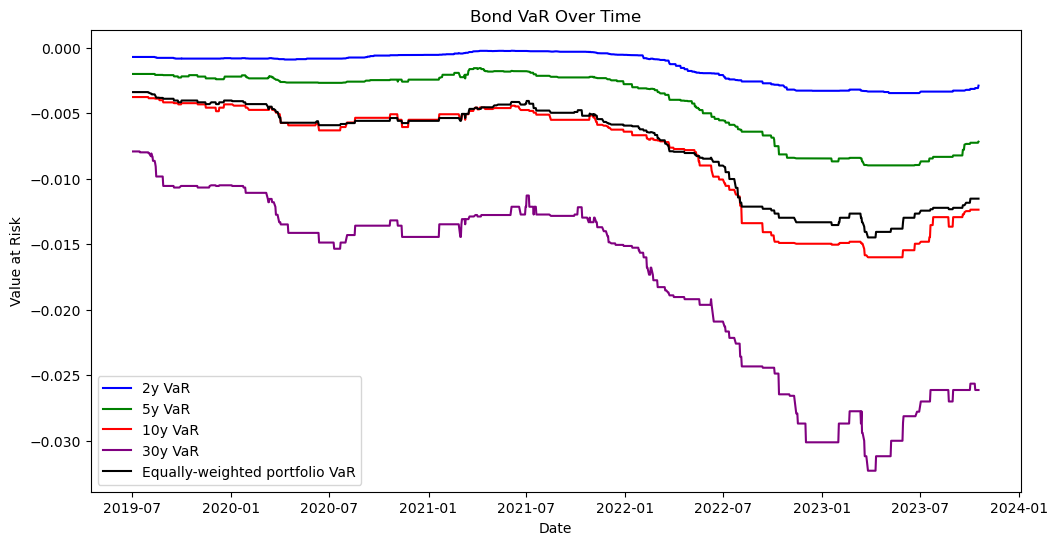

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rolling_window = 252  # Two years of trading days
threshold = 0.05  # 5% threshold
bond_rets['port'] = bond_rets.mean(axis=1)

# Initialize lists to store VaR values for each column
var_values_2y = []
var_values_5y = []
var_values_10y = []
var_values_30y = []
var_values_port = []

# Calculate VaR for each column using a rolling window
for i in range(rolling_window, len(bond_rets)):
    returns_window = bond_rets.iloc[i - rolling_window:i]
    
    # Calculate VaR for each column
    var_2y = np.percentile(returns_window['2y'], threshold * 100)
    var_5y = np.percentile(returns_window['5y'], threshold * 100)
    var_10y = np.percentile(returns_window['10y'], threshold * 100)
    var_30y = np.percentile(returns_window['30y'], threshold * 100)
    var_port = np.percentile(returns_window['port'], threshold * 100)
    
    var_values_2y.append(var_2y)
    var_values_5y.append(var_5y)
    var_values_10y.append(var_10y)
    var_values_30y.append(var_30y)
    var_values_port.append(var_port)

# Create DataFrames for VaR
var_df_2y = pd.DataFrame({'VaR_2y': var_values_2y}, index=bond_rets.index[rolling_window:])
var_df_5y = pd.DataFrame({'VaR_5y': var_values_5y}, index=bond_rets.index[rolling_window:])
var_df_10y = pd.DataFrame({'VaR_10y': var_values_10y}, index=bond_rets.index[rolling_window:])
var_df_30y = pd.DataFrame({'VaR_30y': var_values_30y}, index=bond_rets.index[rolling_window:])
var_df_port = pd.DataFrame({'VaR_port': var_values_port}, index=bond_rets.index[rolling_window:])

# Plot VaR for each column
plt.figure(figsize=(12, 6))
plt.plot(var_df_2y.index, var_df_2y['VaR_2y'], label='2y VaR', color='blue')
plt.plot(var_df_5y.index, var_df_5y['VaR_5y'], label='5y VaR', color='green')
plt.plot(var_df_10y.index, var_df_10y['VaR_10y'], label='10y VaR', color='red')
plt.plot(var_df_30y.index, var_df_30y['VaR_30y'], label='30y VaR', color='purple')
plt.plot(var_df_port.index, var_df_port['VaR_port'], label='Equally-weighted portfolio VaR', color='black')
plt.xlabel('Date')
plt.ylabel('Value at Risk')
plt.title('Bond VaR Over Time')
plt.legend()
plt.show()

### The rate hikes had more impact on the risk of securities with greater durations

# 19.5 Risk management of options

In [16]:
import yfinance as yf
tlt = yf.Ticker('tlt')
spy = yf.Ticker('spy')
vix = yf.Ticker('^VIX')

## a. Consider an options portfolio with the following positions and hedges

In [123]:
spy.option_chain('2023-11-24')[1].loc[39] # short 1-month put
# + long position in spy

contractSymbol              SPY231124P00421000
lastTradeDate        2023-10-20 20:05:00+00:00
strike                                   421.0
lastPrice                                 8.63
bid                                       8.71
ask                                       8.77
change                                    1.84
percentChange                        27.098677
volume                                     766
openInterest                               658
impliedVolatility                     0.170479
inTheMoney                               False
contractSize                           REGULAR
currency                                   USD
Name: 39, dtype: object

In [18]:
vix.option_chain('2023-11-22')[1].loc[6] # short 1 month put
vix.option_chain('2024-01-17')[1].loc[15] # long 3 month put

contractSymbol              VIX240117P00021000
lastTradeDate        2023-10-20 20:04:00+00:00
strike                                    21.0
lastPrice                                  3.0
bid                                       2.87
ask                                       3.05
change                                   -0.13
percentChange                        -4.153358
volume                                 10902.0
openInterest                             20303
impliedVolatility                     0.794924
inTheMoney                               False
contractSize                           REGULAR
currency                                   USD
Name: 15, dtype: object

In [21]:
tlt.option_chain('2023-11-24')[0].loc[3]  # long 1 month call
tlt.option_chain('2023-11-24')[1].loc[10] # long 1 month put

contractSymbol              TLT231124P00083500
lastTradeDate        2023-10-20 19:05:04+00:00
strike                                    83.5
lastPrice                                 2.35
bid                                       2.36
ask                                       2.41
change                                   -0.07
percentChange                        -2.892569
volume                                      54
openInterest                                69
impliedVolatility                     0.224373
inTheMoney                                True
contractSize                           REGULAR
currency                                   USD
Name: 10, dtype: object

## b. Looking at this portfolio, what does the investor want to happen? What are the biggest risks for this investor? Can you explain this portfolio in terms of its Greek exposures?

In [8]:
from py_vollib.black_scholes import black_scholes
black_scholes(flag='p', S=421.0, K=421.0, t=1/12, r=0.054/12, sigma=0.170479) # decent approximation

8.184496526753506

In [32]:
from py_vollib.black_scholes.greeks.analytical import delta
from py_vollib.black_scholes.greeks.analytical import gamma
from py_vollib.black_scholes.greeks.analytical import theta
from py_vollib.black_scholes.greeks.analytical import vega
from py_vollib.black_scholes.greeks.analytical import rho

delta_spy =-delta(flag='p', S=421.0, K=421.0, t=1/12, r=0.054/12, sigma=0.170479)
gamma_spy =-gamma(flag='p', S=421.0, K=421.0, t=1/12, r=0.054/12, sigma=0.170479)
theta_spy =-theta(flag='p', S=421.0, K=421.0, t=1/12, r=0.054/12, sigma=0.170479)
vega_spy =-vega(flag='p', S=421.0, K=421.0, t=1/12, r=0.054/12, sigma=0.170479)
rho_spy =rho(flag='p', S=421.0, K=421.0, t=1/12, r=0.054/12, sigma=0.170479)

delta_shortvix =-delta(flag='p', S=21.0, K=21.0, t=1/12, r=0.054/12, sigma=0.790041)
gamma_shortvix =-gamma(flag='p', S=21.0, K=21.0, t=1/12, r=0.054/12, sigma=0.790041)
theta_shortvix =-theta(flag='p', S=21.0, K=21.0, t=1/12, r=0.054/12, sigma=0.790041)
vega_shortvix =-vega(flag='p', S=21.0, K=21.0, t=1/12, r=0.054/12, sigma=0.790041)
rho_shortvix =rho(flag='p', S=21.0, K=21.0, t=1/12, r=0.054/12, sigma=0.790041)

delta_longvix =delta(flag='p', S=21.0, K=21.0, t=3/12, r=0.054/4, sigma=1.275394)
gamma_longvix =gamma(flag='p', S=21.0, K=21.0, t=3/12, r=0.054/4, sigma=1.275394)
theta_longvix =theta(flag='p', S=21.0, K=21.0, t=3/12, r=0.054/4, sigma=1.275394)
vega_longvix =vega(flag='p', S=21.0, K=21.0, t=3/12, r=0.054/4, sigma=1.275394)
rho_longvix =rho(flag='p', S=21.0, K=21.0, t=3/12, r=0.054/4, sigma=1.275394)

delta_tlt1 =delta(flag='p', S=83.5, K=83.5, t=1/12, r=0.054/12, sigma=0.238289)
gamma_tlt1 =gamma(flag='p', S=83.5, K=83.5, t=1/12, r=0.054/12, sigma=0.238289)
theta_tlt1 =theta(flag='p', S=83.5, K=83.5, t=1/12, r=0.054/12, sigma=0.238289)
vega_tlt1 =vega(flag='p', S=83.5, K=83.5, t=1/12, r=0.054/12, sigma=0.238289)
rho_tlt1 =rho(flag='p', S=83.5, K=83.5, t=1/12, r=0.054/12, sigma=0.238289)

delta_tlt2 =delta(flag='c', S=83.5, K=83.5, t=1/12, r=0.054/12, sigma=0.224373)
gamma_tlt2 =gamma(flag='c', S=83.5, K=83.5, t=1/12, r=0.054/12, sigma=0.224373)
theta_tlt2 =theta(flag='c', S=83.5, K=83.5, t=1/12, r=0.054/12, sigma=0.224373)
vega_tlt2 =vega(flag='c', S=83.5, K=83.5, t=1/12, r=0.054/12, sigma=0.224373)
rho_tlt2 =rho(flag='c', S=83.5, K=83.5, t=1/12, r=0.054/12, sigma=0.224373)

# Greeks for VIX positions
vix_positions = {
    'delta': delta_shortvix + delta_longvix,
    'gamma': gamma_shortvix + gamma_longvix,
    'theta': theta_shortvix + theta_longvix,
    'vega': vega_shortvix + vega_longvix,
    'rho': rho_shortvix + rho_longvix
}

# Greeks for TLT positions
tlt_positions = {
    'delta': delta_tlt1 + delta_tlt2,
    'gamma': gamma_tlt1 + gamma_tlt2,
    'theta': theta_tlt1 + theta_tlt2,
    'vega': vega_tlt1 + vega_tlt2,
    'rho': rho_tlt1 + rho_tlt2
}
print("Greeks for SPY positions:")
print(f"Total Delta SPY: {delta_spy+0.5}")
print(f"Total Gamma SPY: {gamma_spy}")
print(f"Total Theta SPY: {theta_spy}")
print(f"Total Vega SPY: {vega_spy}")
print(f"Total Rho SPY: {rho_spy}")

print("Greeks for VIX positions:")
print(f"Total Delta VIX: {vix_positions['delta']}")
print(f"Total Gamma VIX: {vix_positions['gamma']}")
print(f"Total Theta VIX: {vix_positions['theta']}")
print(f"Total Vega VIX: {vix_positions['vega']}")
print(f"Total Rho VIX: {vix_positions['rho']}")

print("\nGreeks for TLT positions:")
print(f"Total Delta TLT: {tlt_positions['delta']}")
print(f"Total Gamma TLT: {tlt_positions['gamma']}")
print(f"Total Theta TLT: {tlt_positions['theta']}")
print(f"Total Vega TLT: {tlt_positions['vega']}")
print(f"Total Rho TLT: {tlt_positions['rho']}")

# Summing up the Greeks across positions
total_delta = delta_spy + 0.5 + delta_shortvix + delta_longvix + delta_tlt1 + delta_tlt2 # 0.5 from the underlying position
total_gamma = gamma_spy + gamma_shortvix + gamma_longvix + gamma_tlt1 + gamma_tlt2
total_theta = theta_spy + theta_shortvix + theta_longvix + theta_tlt1 + theta_tlt2
total_vega = vega_spy + vega_shortvix + vega_longvix + vega_tlt1 + vega_tlt2
total_rho = rho_spy + rho_shortvix + rho_longvix + rho_tlt1 + rho_tlt2

print("Total Greeks for the portfolio:")
print(f"Total Delta: {total_delta}")
print(f"Total Gamma: {total_gamma}")
print(f"Total Theta: {total_theta}")
print(f"Total Vega: {total_vega}")
print(f"Total Rho: {total_rho}")

Greeks for SPY positions:
Total Delta SPY: 0.9871457297529599
Total Gamma SPY: -0.019245189276829874
Total Theta SPY: 0.13317233690261282
Total Vega SPY: -0.4845917560602874
Total Rho SPY: -0.17772737396062468
Greeks for VIX positions:
Total Delta VIX: 0.08103867143800558
Total Gamma VIX: -0.05447621229435458
Total Theta VIX: 0.0037646133111269194
Total Vega VIX: 0.01572184033032824
Total Rho VIX: -0.04213042127059459

Greeks for TLT positions:
Total Delta TLT: 0.031117839459277152
Total Gamma TLT: 0.1431110846000324
Total Theta TLT: -0.07305696062539752
Total Vega TLT: 0.19217872452575574
Total Rho TLT: -0.001540952586719338
Total Greeks for the portfolio:
Total Delta: 1.0993022406502426
Total Gamma: 0.06938968302884796
Total Theta: 0.06387998958834222
Total Vega: -0.27669119120420343
Total Rho: -0.22139874781793858


### The position in SPY is a covered put, which means we own the underlying and earn an extra income with the 1-month put option sold, therefore, the delta is almost identical to simply owning the underlying. In the VIX we own a calendar spread, so we want the sold put option to expiry worthless in 1 month but then we will benefit of an increase in VIX (SPY 30-day implied vol) price. Finally, we own a straddle on TLT so we will benefit of an increase in both implied and realized vol (vega and gamma) in this instrument.  

## c. Generate a time series of realized volatility for each underlying asset, which will be used as a proxy for implied volatility. Plot the time series and comment on their shape.

In [1]:
import yfinance as yf

# Define the tickers for the assets
tickers = ["SPY", "^VIX", "TLT"]

# Define the start and end dates for the historical data
start_date = "2019-01-01"
end_date = "2023-12-31"

# Use yfinance to download historical price data
data = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]
rets = data.pct_change().dropna()

[*********************100%%**********************]  3 of 3 completed


In [2]:
import pandas as pd
vol_data = rets.rolling(window=252).std()
vol_data=vol_data[251:]

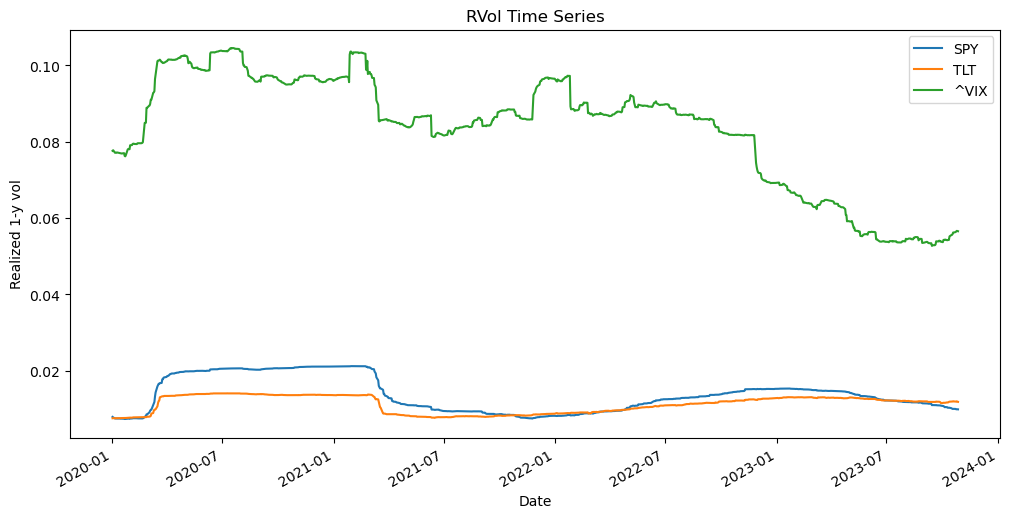

In [4]:
import matplotlib.pyplot as plt
vol_data.plot(figsize=(12, 6))  # simply plot the std of returns 
plt.title('RVol Time Series')
plt.xlabel('Date')
plt.ylabel('Realized 1-y vol')
plt.legend()
plt.show()

### The shape of each curve is what we would expect, with increased vol in march '20.

## d. Assuming a flat volatility surface as defined by the realized volatility series that you calculate, use historical simulation to estimate VaR and CVaR for this options portfolio.

### I assume the question as to simulate the pnl changing the implied vol, as proxied by the realized vol in c. We will simulate the rolling of an ATM option monthly, but we do not take in account the change in time to expiration, or interest rates changes. We only work with the option over SPY, we plug the vol values into the BS formula, compute returns (we simply take a 0 return at the rolling day) and compute VaR with 1-year rolling window.

In [106]:
import yfinance as yf
spy_price = yf.download('SPY', start='2020-01-02', end='2023-10-28')['Adj Close']

[*********************100%%**********************]  1 of 1 completed


In [107]:
from py_vollib.black_scholes import black_scholes

# Assuming vol_data['SPY'] holds your SPY data
sigma_values = vol_data['SPY']  # Replace with your actual column name

spy_optionprice = []  # Initialize an empty list to store option prices

for i in range(len(sigma_values)):
    days_elapsed = i % 30
    K = spy_price[i] if days_elapsed == 0 else spy_price[i - days_elapsed]
  #  print(K,spy_price[i])
    option_price = black_scholes(flag='p', S=spy_price[i], K=K, t=1/12, r=0.054/12, sigma=sigma_values[i])
    spy_optionprice.append(option_price)

option_data = pd.DataFrame()
option_data['SPY'] = pd.Series(spy_optionprice)

In [112]:
def calculate_returns(data):
    returns = []
    prev_val = data[0]  # store the first value
    for i in range(1, len(data)):
        if i % 30 == 0:
            prev_val = 0  # update the previous value when rollin the opt pos
            returns.append(prev_val)
        else:
            returns.append(data[i] - data[i - 1])
    return returns

adjusted_returns = calculate_returns(option_data['SPY'])

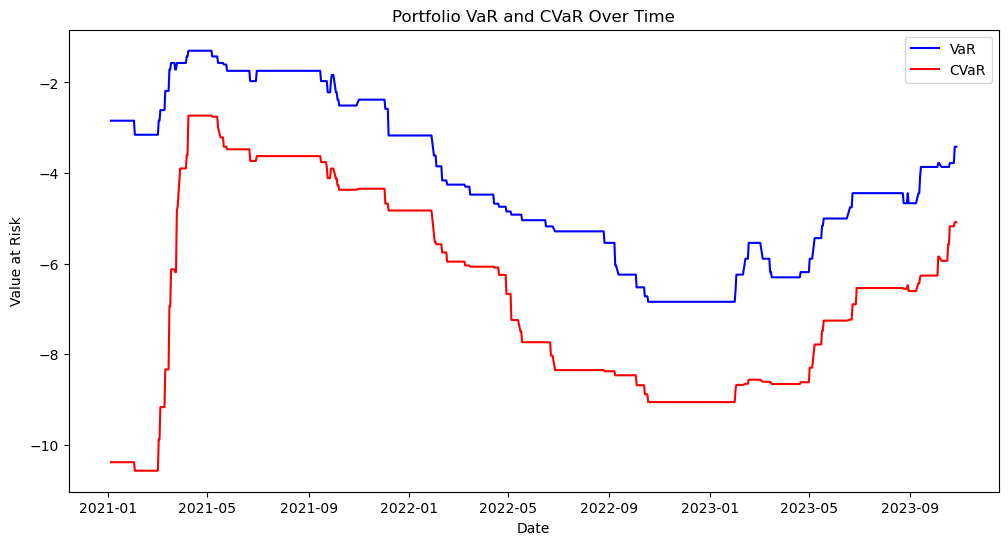

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'option_data' contains the series for VaR calculation

# Parameters
rolling_window = 252  # Two years of trading days
threshold = 0.05  # 5% threshold

# Initialize lists to store VaR and CVaR values
var_values = []
cvar_values = []

# Calculate VaR and CVaR using a rolling window
for i in range(rolling_window, len(adjusted_returns)):
    returns_window = adjusted_returns[i - rolling_window:i]
    var = np.percentile(returns_window, threshold * 100)
    cvar = np.mean([x for x in returns_window if x <= var])
    var_values.append(var)
    cvar_values.append(cvar)

# Create a DataFrame for VaR and CVaR
var_df = pd.DataFrame({'VaR': var_values, 'CVaR': cvar_values}, index=vol_data['SPY'].iloc[253:].index)

# Plot VaR and CVaR
plt.figure(figsize=(12, 6))
plt.plot(var_df.index, var_df['VaR'], label='VaR', color='blue')
plt.plot(var_df.index, var_df['CVaR'], label='CVaR', color='red')
plt.xlabel('Date')
plt.ylabel('Value at Risk')
plt.title('Portfolio VaR and CVaR Over Time')
plt.legend()
plt.show()

### The scale is in SPY points

# 19.7 Stress tests

## a. Download data for all 500 S&P constituents. Generate a random portfolio of the underlying constituents.

In [38]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import yfinance as yf

# Scrape the S&P 500 tickers from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
html = requests.get(url).text
soup = BeautifulSoup(html, 'html.parser')
table = soup.find('table', {'class': 'wikitable sortable'})

tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text.strip()
    tickers.append(ticker)

sp500_price = yf.download('^GSPC', start='2020-01-01', end='2023-12-31')['Adj Close']
# Download historical data for S&P 500 constituents
sp500_data = yf.download(tickers, start='2020-01-01', end='2023-12-31')['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  503 of 503 completed


2 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-01-01 -> 2023-12-31)')


In [3]:
import pandas as pd
import numpy as np
import yfinance as yf

tickers = list(set(tickers))

# Generate random weights for the portfolio
weights = np.random.dirichlet(np.ones(494), size=1)[0]

# Create a dictionary to store the weights for each ticker
portfolio_weights = {ticker: weight for ticker, weight in zip(tickers, weights)}

In [39]:
sp500_return = sp500_price.pct_change()
# Compute daily returns for each constituent
constituent_returns = sp500_data.pct_change()

constituent_returns = constituent_returns[1:]
constituent_returns = constituent_returns.dropna(axis=1)

# Multiply the returns by the portfolio weights
portfolio_daily_returns = (constituent_returns * weights).sum(axis=1)

# Calculate cumulative portfolio returns
cumulative_portfolio_returns = (1 + portfolio_daily_returns).cumprod() - 1

# Display the cumulative portfolio returns
print(cumulative_portfolio_returns)

Date
2020-01-03   -0.004925
2020-01-06   -0.003967
2020-01-07   -0.004238
2020-01-08   -0.000854
2020-01-09    0.005040
                ...   
2023-10-26    0.503698
2023-10-27    0.486530
2023-10-30    0.496204
2023-10-31    0.511237
2023-11-01    0.520037
Length: 965, dtype: float64


## b. Consider an equity drawdown sell-off by 20% and perform a stress test. Carefully describe your correlation assumptions.

### We cannot model correlations using a copula given the dimensions of out dataset. We will simply estimate the beta coefficients of each sp500 component from 01 of feb '20 to 31 of july '20, this is the covid-19 crash and quick recovery afterwards. Then we multiply a -20% on the next day from today by the beta, and visualize how the crash affected each stock. 

In [11]:
import pandas as pd
import statsmodels.api as sm

start_date = pd.to_datetime('2020-02-01')
end_date = pd.to_datetime('2023-06-30')

# Subset the data using datetime objects
sp500_return_subset = sp500_return.loc[start_date:end_date]
constituent_returns_subset = constituent_returns.loc[start_date:end_date]

# List to store regression results
regression_results = []

# Iterate through each constituent's return data
for constituent in constituent_returns_subset.columns:
    # Fit linear regression of constituent's return against S&P 500 index return
    X = sm.add_constant(sp500_return_subset)
    y = constituent_returns_subset[constituent]
    model = sm.OLS(y, X, missing='drop').fit()
    regression_results.append({
        'constituent': constituent,
        'intercept': model.params[0],
        'sp500_beta': model.params[1],
        'r_squared': model.rsquared
    })

# Create a DataFrame from the regression results
regression_df = pd.DataFrame(regression_results)

print(regression_df)

    constituent  intercept  sp500_beta  r_squared
0             A   0.000182    0.963931   0.569389
1           AAL  -0.000190    1.365934   0.225934
2          AAPL   0.000757    1.190300   0.677204
3          ABBV   0.000615    0.569837   0.284799
4           ABT   0.000089    0.813143   0.466232
..          ...        ...         ...        ...
489         YUM   0.000158    0.809846   0.448765
490         ZBH  -0.000154    0.895349   0.390895
491        ZBRA  -0.000034    1.294191   0.559827
492        ZION  -0.000522    1.148409   0.299140
493         ZTS   0.000044    0.933710   0.547859

[494 rows x 4 columns]


In [8]:
# Apply stress test to the next day's returns of constituents
stress_tested_returns = regression_df['sp500_beta'].values * -0.2

### Let us add the stress tested return

In [9]:
stress_tested_returns = pd.DataFrame(stress_tested_returns).T
stress_tested_returns.columns = constituent_returns.columns

In [10]:
constituent_returnstest = pd.concat([constituent_returns, stress_tested_returns], axis=0)

In [77]:
daily_returnstest = (constituent_returnstest * weights)
# Calculate cumulative portfolio returns
cumulative_returnstest = (1 + daily_returnstest).cumprod() - 1

In [12]:
portfolio_daily_returnstest = (constituent_returnstest * weights).sum(axis=1)
# Calculate cumulative portfolio returns
cumulative_portfolio_returnstest = (1 + portfolio_daily_returnstest).cumprod() - 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


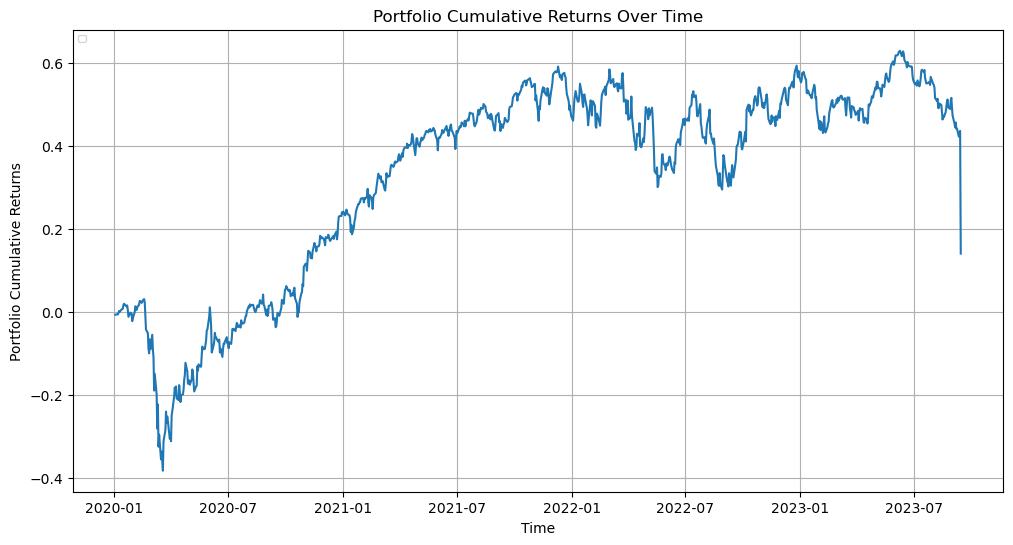

In [27]:
import matplotlib.pyplot as plt

# Set the index explicitly and then plot the data
cumulative_portfolio_returnstest.index = pd.date_range(start='2020-01-03', periods=len(cumulative_portfolio_returnstest), freq='B')

plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
plt.plot(cumulative_portfolio_returnstest.index, cumulative_portfolio_returnstest)

plt.title('Portfolio Cumulative Returns Over Time')
plt.xlabel('Time')
plt.ylabel('Portfolio Cumulative Returns')
plt.legend(loc='upper left', fontsize='x-small')  # You can adjust the legend position and font size
plt.grid(True)
plt.show()

### A sample of 15 securities

<Axes: >

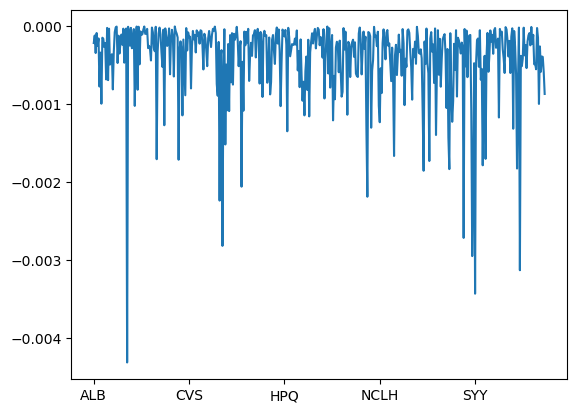

In [47]:
st=daily_returnstest.iloc[-1]
st[20:].plot()

# 19.8 Monte Carlo Simulation Based VaR & CVaR

## a. Download data for this set of ETFs from a source of your choice and validate the data for anomalies.

In [122]:
import yfinance as yf

# Define the list of tickers
tickers = [
    "SPY",  # S&P 500 ETF
    "DBC",  # Invesco DB Commodity Index Tracking Fund
    "VXX",  # iPath Series B S&P 500 VIX Short-Term Futures ETN
    "LQD",  # iShares iBoxx $ Investment Grade Corporate Bond ETF
    "ACWI", # iShares MSCI ACWI ETF (Global Equities)
    "AGG",  # iShares Core U.S. Aggregate Bond ETF
    "IAGG", # iShares International Aggregate Bond ETF
    "UNG"   # United States Natural Gas Fund, LP
]

# Fetch data using yfinance
data = yf.download(tickers, start="2022-01-01", end="2023-01-01")['Adj Close'] # 1 year

[*********************100%%**********************]  8 of 8 completed


## b. Calculate an inverse volatility weighted portfolio of the assets using the entire period in your volatility calculation.

In [123]:
returns = data.pct_change().dropna()

In [110]:
def calc_inv_vol_weights(returns):
    
    vol = np.divide(1.0, np.std(returns))
    volsum = vol.sum()
    return np.divide(vol, volsum)

In [131]:
weights =calc_inv_vol_weights(returns).values
weights

array([0.08600531, 0.24472041, 0.07402674, 0.29529598, 0.16008457,
       0.08067108, 0.02571459, 0.03348132])

## c. Calculate a vector of expected returns and a covariance matrix of the underlying assets.

In [165]:
w_cumreturns = (returns*weights +1).cumprod() -1

In [209]:
exp_returns = w_cumreturns.iloc[-1] # returns
exp_returns

ACWI   -0.015782
AGG    -0.031368
DBC     0.015316
IAGG   -0.031791
LQD    -0.028487
SPY    -0.014375
UNG     0.009849
VXX    -0.002559
Name: 2022-12-30 00:00:00, dtype: float64

In [158]:
cov_returns = returns.cov() # cov matrix
cov_returns

,ACWI,AGG,DBC,IAGG,LQD,SPY,UNG,VXX
ACWI,0.000206,0.000024,0.000045,0.000018,0.000054,0.000215,0.000110,-0.000366
AGG,0.000024,0.000025,0.000006,0.000017,0.000037,0.000025,0.000020,-0.000044
DBC,0.000045,0.000006,0.000278,0.000002,0.000010,0.000042,0.000248,-0.000050
IAGG,0.000018,0.000017,0.000002,0.000017,0.000025,0.000019,0.000010,-0.000028
LQD,0.000054,0.000037,0.000010,0.000025,0.000059,0.000056,0.000030,-0.000097
SPY,0.000215,0.000025,0.000042,0.000019,0.000056,0.000234,0.000118,-0.000385
UNG,0.000110,0.000020,0.000248,0.000010,0.000030,0.000118,0.002303,-0.000196
VXX,-0.000366,-0.000044,-0.000050,-0.000028,-0.000097,-0.000385,-0.000196,0.001358


## d. Test the individual return series to see if they are Gaussian, using a QQ plot or another technique of your choice. Does it appear the returns are normally distributed?

In [138]:
returns.iloc[:,0]

Date
2022-01-04   -0.000846
2022-01-05   -0.016282
2022-01-06   -0.002105
2022-01-07   -0.000192
2022-01-10   -0.002877
                ...   
2022-12-23    0.004606
2022-12-27   -0.000353
2022-12-28   -0.012937
2022-12-29    0.017395
2022-12-30   -0.005973
Name: ACWI, Length: 250, dtype: float64

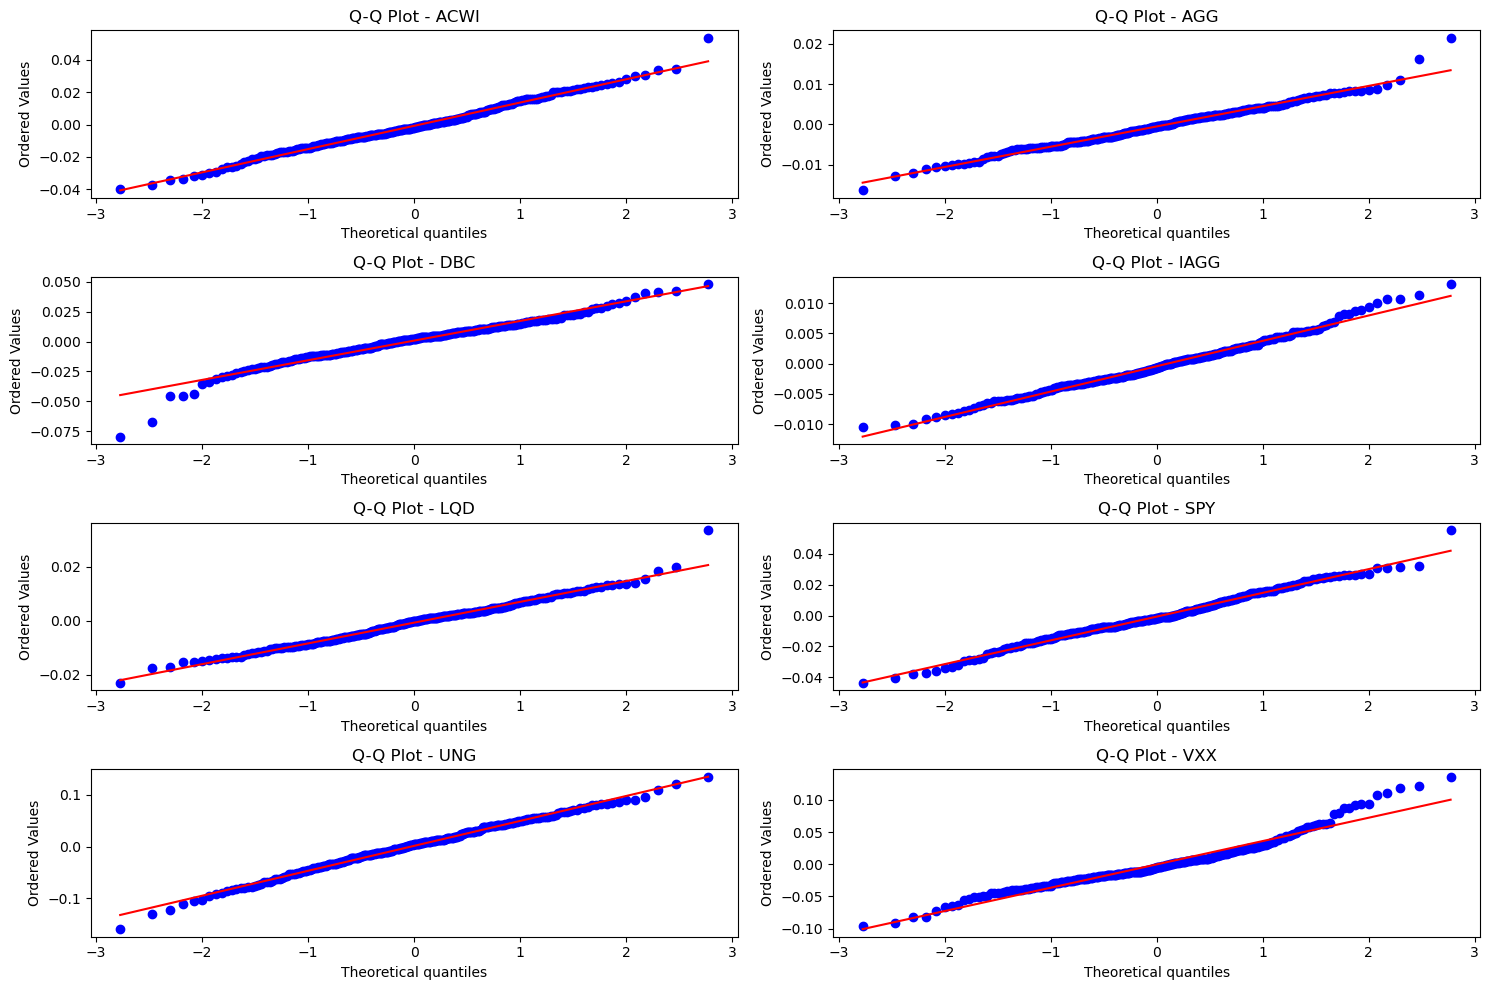

In [155]:
import matplotlib.pyplot as plt
from scipy import stats

column_names = returns.columns  # Get the names of the columns

num_columns = len(column_names)  # Number of columns in the DataFrame

fig, axs = plt.subplots(4, num_columns // 3, figsize=(15, 10))

for i, column_name in enumerate(column_names):
    row = i // (num_columns // 3)
    col = i % (num_columns // 3)

    # Extracting the daily returns for each named column
    daily_returns = returns[column_name]

    # Generate Q-Q plot for the current column
    stats.probplot(daily_returns, dist="norm", plot=axs[row, col])
    axs[row, col].set_title(f'Q-Q Plot - {column_name}')

plt.tight_layout()
plt.show()

### The tails differ substantially

## e. Perform an eigenvalue decomposition of the covariance matrix, is it positive definite? Positive semi-definite? Explain how you know.

In [163]:
cov_returns.shape

(8, 8)

In [162]:
np.linalg.matrix_rank(cov_returns) # full rank

8

In [160]:
eigenvalues, _ = np.linalg.eig(cov_returns)

# To know if it is positive definite we need all eigenvalues positive
if all(eigenvalues > 0):
    print("The matrix is positive definite.")
elif all(eigenvalues >= 0):
    print("The matrix is positive semi-definite.")
else:
    print("The matrix is neither positive definite nor positive semi-definite.")

The matrix is positive definite.


## f. Implement the Monte Carlo based approach to calculating VaR and CVaR assuming the joint distribution is Gaussian. Comment on any assumptions that you believe may be violated and how you think that might impact the results.

### Let us follow the steps pointed in the book:
### 1. Estimate a covariance matrix and set of assumed means (we did this in c.)

In [228]:
exp_returns

ACWI   -0.015782
AGG    -0.031368
DBC     0.015316
IAGG   -0.031791
LQD    -0.028487
SPY    -0.014375
UNG     0.009849
VXX    -0.002559
Name: 2022-12-30 00:00:00, dtype: float64

In [207]:
cov_returns

,ACWI,AGG,DBC,IAGG,LQD,SPY,UNG,VXX
ACWI,0.000206,0.000024,0.000045,0.000018,0.000054,0.000215,0.000110,-0.000366
AGG,0.000024,0.000025,0.000006,0.000017,0.000037,0.000025,0.000020,-0.000044
DBC,0.000045,0.000006,0.000278,0.000002,0.000010,0.000042,0.000248,-0.000050
IAGG,0.000018,0.000017,0.000002,0.000017,0.000025,0.000019,0.000010,-0.000028
LQD,0.000054,0.000037,0.000010,0.000025,0.000059,0.000056,0.000030,-0.000097
SPY,0.000215,0.000025,0.000042,0.000019,0.000056,0.000234,0.000118,-0.000385
UNG,0.000110,0.000020,0.000248,0.000010,0.000030,0.000118,0.002303,-0.000196
VXX,-0.000366,-0.000044,-0.000050,-0.000028,-0.000097,-0.000385,-0.000196,0.001358


### 2. Generate a series of correlated asset returns according to a multivariate normal. Instead of choosing a return for each time-step, in this framework we can generate a single return spanning the entire period of analysis. Continue for many paths, and calculate the change in the portfolio value along each path.

In [234]:
sim_data = np.random.multivariate_normal(exp_returns, cov_returns, size=10000)

(sim_data[0]*weights).sum() # this way we see the change in portfolio value along each path

-0.025773945870996847

### 3. Using these simulated paths, calculate the relevant risk metric, such as VaR or CVaR. Again, VaR is simply the nth percentile return whereas CVaR is the average of the returns that are less than or equal to the calculated VaR.

In [235]:
portfolio_returns = []

for i in range(len(sim_data)):
    portfolio_return = (sim_data[i] * weights).sum()
    portfolio_returns.append(portfolio_return)
    
var = np.percentile(portfolio_returns, 5) # 5% confidence level
cvar = np.mean([ret for ret in portfolio_returns if ret <= var])

print(f"Value at Risk (VaR) at 95% confidence level: {var}")
print(f"Conditional Value at Risk (CVaR) at 95% confidence level: {cvar}")

Value at Risk (VaR) at 95% confidence level: -0.03144705299871237
Conditional Value at Risk (CVaR) at 95% confidence level: -0.0336510651457225


### In contrast with previous VaR/CVaR calculations where we used a rolling window to estimate the daily risk metric, we are now showing the annual risk at 95% using only 1 year of data and simulating many return paths for our portfolio given a Gaussian distribution. 1 year is not representative enough (although it was a specially bad year), and the Gaussian distr. will underestimate the VaR/CVaR as we are estimating the tail risk of our returns using a Normal.